### TODO:


- shift 'high' & 'low'and other variables used in the regression by one to avoid forward bias for volume / volatility computation
- Use GridsearchCV to find the optimal number of trees for random-forest regressor.
- Should we consider log of volume and log of moving averages?
- Compute volatility out of design matrix:
    - should we use lecture7 slide 18/28 Advanced derivatives definition i.e.: 
    - $$\sigma_R = 100 \cdot sqrt( \frac{252}{N_{days}} \cdot \sum^{N_{days}}_{i=1} (ln(\frac{S_i}{S_{i-1}}))^2 ) $$


### Assumptions undertaken | achieved tasks:
- Include transactions FROM exchanges to any wallet, merge the two dataframes (TO and FROM exchanges). 
    - Queried the FROM exchange dataframe with a new SQL query
    - Union the two datasets and drop the duplicates on the transaction_hash
    - compute the corresponding count of transactions to exchanges
    - TODO (as of 23/12/19): 
        - ~~update overleaf with new SQL query~~ (26/12/19)
        - make sure the from_exchange and to_exchange sum variables work as intended

    
- Plot ACF & PACF to obtain the good number of lags + complete the overleaf part.
    - Number of lags determined by the minimization of the BIC
    - ACF & PACF are plot
    - TODO: 
        - overleaf
- Re-queried data with daily intervals instead of hourly returns
    - updated the period burn to match new frequency
    - updated the rolling plots to match new frequency
    - TODO: 
        - ~~update overleaf~~ (26/12/19)
    - We re-queried on-chain data as of 21/12/19 - data should match at the daily level
    
- add intercept in design matrix
- removal of all transactions with zero 'close' & removal of first two weeks of each trading period  
    - Assumption: on-chain transactions prior to quotation are left aside.
    - Upsides: allows to remove prices equal to 0 and then remove first two weeks of trading (to avoid possible extreme outliers)
- include back on-chain transactions FROM exchanges and add a dummy variable identifying whether it comes FROM or TO an exchange
    - added a count variable for transactions from one exchange's wallet to another
    - ~~underlying data in its current iteration (as of 21/12/19) only has transactions TO exchanges' wallets and not FROM as i.e. if someone had sent money FROM the exchange TO an unknown wallet~~
    - ~~in its previous iteration, we missed transactions from one exchange to another, while they were legitimate~~

We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [20]:
import numpy as np 
import pandas as pd 
import os
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import scipy
import sklearn
import time
import os.path
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, StudentsT

In [3]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [34]:
def format_on_chain_df(dataframe_path, token_initials):
    """######################## Load the dataframe of on-chain transactions #############################"""

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    df = pd.read_csv(dataframe_path.format(token_initials)) # e.g. './data/{}/raw_big_query.csv'.format{token_initials}
    df.block_timestamp = df.block_timestamp.apply(lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') )

    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value=df.value.astype(float)

    exchange_data.Address

    # We create a dummy variable to identify transactions
    # from one exchange's wallet to any address   
    df['from_exchange'] = 0
    # IF the 'from_address' at the given raw IS IN the
    # exchanges' wallet addresses, we set the value to 1
    df.loc[df['from_address'].isin(exchange_data.Address), 'to_exchange'] = 1
    
    # We create a dummy variable to identify transactions
    # TO one exchange's wallet from any wallet   
    df['to_exchange'] = 0
    # IF the 'to_address' at the given raw IS IN the
    # exchanges' wallet addresses, we set the value to 1
    df.loc[df['to_address'].isin(exchange_data.Address), 'to_exchange'] = 1
        
    trans = df
    print('We found {} transactions towards exchanges.'.format( df.shape[0]), 'for ',dataframe_path )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]
        
    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending=False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
    
    return(trans)

In [56]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import scipy
    import sklearn
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
    from sklearn.model_selection import train_test_split
        
    """######################## Load the dataframe of on-chain transactions #############################"""

    df1 = format_on_chain_df('./data/{}/raw_big_query_TO_EXCHANGES.csv'.format(token_initials),token_initials)
    df2 = format_on_chain_df('./data/{}/raw_big_query_FROM_EXCHANGES.csv'.format(token_initials),token_initials)
    
    trans = (
        pd
        .concat(
            [
                df1,
                df2
            ],
            ignore_index = True
        )
        .drop_duplicates(subset = 'transaction_hash')
        .reset_index(drop = True)
    )

    print('number of on-chain transactions: ', trans.shape[0])
    print('number of duplicates: ', - (trans.shape[0] - (df1.shape[0] + df2.shape[0])),'\n')
       
        
    """######################## Load the dataframe of off-chain transactions #############################"""  
    
    price_raw = pd.read_csv('./data/{}/raw_crypto_compare.csv'.format(token_initials))
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    if initial_date:
        price = price.loc[price.time >initial_date]

    # "volumeto" means the volume in the currency that is being traded
    # "volumefrom" means the volume in the base currency that things are traded into.
    price = (
        price
        .drop(
            ['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'],
            axis=1
        )
    )
    
    # We consider the BTC volume as what we refer to as 'volume'
    price = (
        price
        .rename(columns={'volumeto':'volume'}) 
        .drop('Unnamed: 0', axis=1)
    )
    
    # filters out all zero prices
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} off-chain daily intervals.'.format( price.shape[0]) )
    
    '''############################ COMPUTE ON-CHAIN AGGREGATES ##################################'''
    
    # We compute the returns of the closing prices
    price.loc[:,'returns'] = np.log(price['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    min_trans_time, max_trans_time = trans.time.iloc[[0,-1]].values

    # We only keep the transactions for which we have price data
    #trans = trans.loc[(trans['time'] >= min_time)]   
    '''
    TEST PURPOSE: 
    we only keep the transactions for which we have on-chain data
    Current maximum off_chain timestamp as of 21/12/2019 is 21/12/2019
    Current maximum on_chain time is 2019-12-21 19:29:00 (as of 21/12/2019)
    '''
    print('Current maximum off_chain time is {}'.format(max_time), 'as of {}'.format(date.today()))
    print('Current maximum on_chain time is {}'.format(max_trans_time), 'as of {}'.format(date.today()))
    price = price.loc[(price['time'] <= max_trans_time)]   
        
    # We create bins of hourly intervals and we aggregate the on-chain transactions in the bins
    cut = pd.cut(trans.time, bins = price.time, duplicates='drop')

    '''
    GOAL: merge on-chain and off-chain datasets.
    PROCEDURE:
    Group by the number of tokens exchanged (value) and compute the sum
    and count of this feature.
    Yields: 'onchain_volume' & 'onchain_trans'
    Perform the same by grouping by 'from_exchange' dummy variable
    and taking a count of it, to obtain the number of 
    transactions coming FROM exchanges
    '''
    data = price

    for _GROUPBY in ['value','from_exchange','to_exchange']:
        # sum variable of FROM exchanges transactions
        trans_cut = trans.groupby(cut)[_GROUPBY].aggregate(['count','sum'])
              
        # We show 5 examples of intervals for readability
        trans_cut.sample(5)
        trans_cut = trans_cut.reset_index()
        trans_cut.time = trans_cut.time.apply(lambda x:x.right)
        trans_cut.time = pd.to_datetime(trans_cut.time)
               
        data = (
            trans_cut
            .merge(data, left_on='time', right_on='time')
        )
        
        if _GROUPBY == 'value':
            data = data.rename(columns={'sum':'onchain_volume', 'count':'onchain_trans'})
            
        elif _GROUPBY == 'from_exchange':
            data = (
                data
                .rename(columns={'sum':'from_exchanges_transactions'})
                .drop('count', axis=1)
            )
        
        elif _GROUPBY == 'to_exchange':
            data = (
                data
                .rename(columns={'sum':'to_exchanges_transactions'})
                .drop('count', axis=1)
            )
    

    '''############################ DATA CLEANING ##################################'''
    # if we have daily intervals: burn the first two weeks i.e. 14 days
    data = data[14:]
    
    # We remove the rows where one value is missing
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) # remove rows with infinite values
        .dropna()
        .reset_index()
        .drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['returns'] >= lower_bound) & (data['returns'] <= upper_bound)]
    data.sort_values('time')   
    
    
    '''############################ GARCH PROCEDURE ##################################'''

    am = ConstantMean(data['returns'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    GARCH_param = (
        pd
        .DataFrame(
            {
                'Asset' : 'Stock',
                'omega' : [res.params['omega']],
                'alpha' : [res.params['alpha[1]']],
                'beta' : [res.params['beta[1]']],
                'nu' : [res.params['nu']],
                'AIC' : [res.aic],
                'BIC' : [res.bic],
                'GARCH parameters' : [[1,1]]
            }
        )
    )
    
    GARCH_param.set_index('Asset', inplace = True)
    
    #display(GARCH_param)
    #display(res.summary())   
    #display(res)

    for p in range(1,9):
        for q in range(1,9):
            am = ConstantMean(data['returns'][1:])
            am.volatility = GARCH(p, 0, q)
            am.distribution = StudentsT()

            res = am.fit(disp = 'off', update_freq = 7)
            #display(res)
            new_GARCH_param = (
                pd
                .DataFrame(
                    {
                        'Asset' : 'Stock',
                        'omega' : [res.params['omega']],
                        'alpha' : [res.params['alpha[1]']],
                        'beta' : [res.params['beta[1]']],
                        'nu' : [res.params['nu']],
                        'AIC' : [res.aic],
                        'BIC' : [res.bic],
                        'GARCH parameters' : [[p,q]]
                    }
                )
            )
            GARCH_param = GARCH_param.append(new_GARCH_param, ignore_index = True, sort=False)

    GARCH_param['_TICKER'] = token_initials
    display(GARCH_param.sort_values(by='BIC').head(10))



    '''############################ PLOTS ##################################'''

    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf

    plot_pacf(data.returns, lags=list(range(1,48)))
    plt.title('Partial Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    plot_acf(data.returns, lags=list(range(1,48)))
    plt.title('Autocorrelation of {} (starting at 1 lag)'.format(token_initials))
    plt.show()
    

    nb_figures = 6
    
    fig, (ax1,ax11, ax5, ax2, ax3, ax4, ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax11.set_title('Daily return of token price')
    ax11.plot(data.time, data.returns)
    ax11.set_ylim((-0.3,0.3))
    
    ax5.set_title('Volume evolution in BTC')
    ax5.plot(data.time, data.volume)

    # Plots if data consist of daily intervals        
    ax2.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax2.plot(data.time,data.volume.rolling(7).mean())
    
    ax3.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax3.plot(data.time,data.onchain_trans.rolling(7).mean())
    
    ax4.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax4.plot(data.time,data.onchain_volume.rolling(7).mean())
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))

    data['intercept'] = 1
    
    data['realized_vol'] = (
        100 * np.sqrt(
            252 * np.square(
                np.log(
                    price['close']/price['close'].shift()
                )
            )
        )
    )
    
    
    display(data.head(20))
    
    '''############################ DESIGN MATRICES ##################################'''
    
    y_returns = data.returns.values
    y_volume = data.volume.values
    
    X_returns = (
        data
        .loc[
            :,
             [
              'intercept', 'onchain_trans', 'onchain_volume',
              'high', 'low', 'volume', 'from_exchanges_transactions'
             ]
            ]
        .shift() # to make sure it has the intended effect only i.e. avoiding forward-looking bias
        .values
    )
    
    X_volume = (
        data
        .loc[
            :,
            [
                'intercept', 'onchain_trans', 'onchain_volume',
                'high', 'low', 'from_exchanges_transactions'
            ]
        ]
        .shift() # to make sure it has the intended effect only i.e. avoiding forward-looking bias
        .values
    )
    
    '''
    The following lines creates an iterator to iterate by pair of y_ | x_
    We would like to run for pairs of y_returns, X_returns, likewise for volume
    '''
    lis = (y_returns, X_returns, y_volume, X_volume)
    it = iter(lis)
    
    for y in it:
        
        X = next(it)
        
        from sklearn.impute import SimpleImputer

        results = {}
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(X_train_train)

        X_train_train = scaler.transform(X_train_train)
        X_train_test = scaler.transform(X_train_test)
        X_test = scaler.transform(X_test)
        
        '''############################ Linear Regression ##################################'''
        from sklearn.linear_model import LinearRegression

        reg = LinearRegression().fit(X_train_train, y_train_train)
              
        # If the the series is Returns, set column_name to 'returns'
        # Else set the column name to 'off-chain volume'
        col_name = 'returns' if np.array_equiv(X, X_returns) else 'off-chain volume' 
        # col_name = 'returns' if (X == X_returns).all() else 'off-chain volume' 
        
        results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
        print('linear regression score of ' + col_name, reg.score(X_test, y_test))

        reg_score = reg.score(X_test, y_test)
        tokens.loc[tokens.initials == token_initials,'linear regression score of '+col_name] = reg_score

        # Start the scatter plots here
        nb_rows = 2
        nb_columns = 1
        
        fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
        ax_linreg.scatter(y_test, reg.predict(X_test))
        ax_linreg.plot(y_test,y_test, 'k')
        ax_linreg.set_title(
            'Linear regression of ' + col_name +
            ' prediction vs. true validation data token {}\n score: {:.3f} '
            .format(token_initials, reg_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
        
        '''############################ RF Regressor ##################################'''
        from sklearn.ensemble import RandomForestRegressor
        
        clf = RandomForestRegressor(n_estimators = 100)
        clf = clf.fit(X_train_train, y_train_train)
        results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
        print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) )
        clf_score = clf.score(X_test,y_test) 

        tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

        ax_tree.scatter(y_test, clf.predict(X_test))
        ax_tree.plot(y_test,y_test, 'k')
        ax_tree.set_title(
            'RF Regressor prediction of ' + col_name +
            ' vs. true validation data token {}\n score:{:.3f} '
            .format(token_initials, clf_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
    
        plt.savefig('./data/{}/regression_plots.png'.format(token_initials))
        plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')


### Run the program

In [57]:
tokens = os.listdir('data')

In [58]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           #os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           # And 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]

tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) #token_data contains all info
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

In [59]:
# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# get a toggle button to remove error boxes once computation is done
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

(65174, 9)

We found 65174 transactions towards exchanges. for  ./data/ENJ/raw_big_query_TO_EXCHANGES.csv


(94206, 9)

We found 94206 transactions towards exchanges. for  ./data/ENJ/raw_big_query_FROM_EXCHANGES.csv
number of on-chain transactions:  157591
number of duplicates:  1789 

We have 781 off-chain daily intervals.
Current maximum off_chain time is 2019-12-21T01:00:00.000000000 as of 2019-12-26
Current maximum on_chain time is 2019-12-23T08:16:02.000000000 as of 2019-12-26


/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin

,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
2,0.000699,0.233525,2.343750e-01,3.297248,-2166.744035,-2138.904780,"[1, 2]",Stock,ENJ
10,0.000699,0.233527,2.342850e-01,3.297411,-2164.744035,-2132.264904,"[2, 2]",Stock,ENJ
11,0.000817,0.290020,3.760808e-14,3.336562,-2167.445810,-2130.326803,"[2, 3]",Stock,ENJ
4,0.000782,0.291633,4.985378e-02,3.337822,-2167.312872,-2130.193865,"[1, 4]",Stock,ENJ
19,0.000817,0.289977,0.000000e+00,3.336727,-2165.445810,-2123.686927,"[3, 3]",Stock,ENJ
12,0.000816,0.289720,4.643130e-16,3.338811,-2165.445783,-2123.686901,"[2, 4]",Stock,ENJ
21,0.000634,0.214446,2.794840e-02,3.605295,-2171.779813,-2120.741179,"[3, 5]",Stock,ENJ
25,0.000511,0.148213,7.670398e-01,3.248720,-2157.259033,-2120.140026,"[4, 1]",Stock,ENJ
20,0.000817,0.289996,2.045145e-11,3.336700,-2163.445810,-2117.047052,"[3, 4]",Stock,ENJ
22,0.000646,0.214688,3.095450e-12,3.607257,-2169.830689,-2114.152179,"[3, 6]",Stock,ENJ


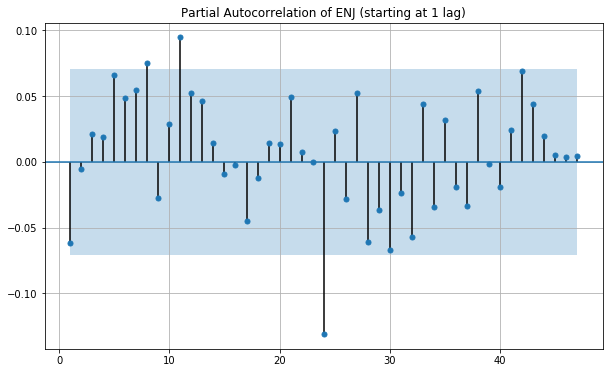

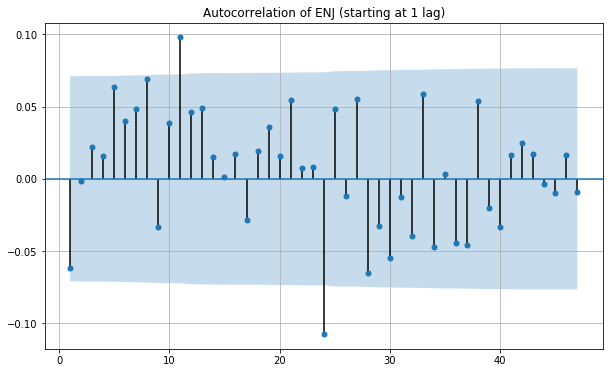

,time,to_exchanges_transactions,from_exchanges_transactions,onchain_trans,onchain_volume,close,high,low,volume,returns,intercept,realized_vol
0,2017-11-16 01:00:00,40,0,175,5.512813e+24,0.000003,0.000003,0.000003,65.40,-0.220959,1,NaN
1,2017-11-17 01:00:00,33,0,123,3.610595e+24,0.000003,0.000003,0.000002,35.77,-0.095310,1,NaN
2,2017-11-18 01:00:00,30,0,89,2.125099e+24,0.000003,0.000003,0.000003,29.16,0.065788,1,NaN
3,2017-11-19 01:00:00,13,0,69,2.680128e+24,0.000003,0.000003,0.000003,75.80,0.103111,1,NaN
4,2017-11-20 01:00:00,24,0,101,3.132567e+24,0.000003,0.000003,0.000003,44.57,-0.066342,1,NaN
5,2017-11-21 01:00:00,15,0,46,1.407458e+24,0.000003,0.000003,0.000003,25.47,-0.040521,1,NaN
6,2017-11-22 01:00:00,8,0,58,1.512207e+25,0.000003,0.000003,0.000002,30.79,0.040521,1,NaN
7,2017-11-23 01:00:00,9,0,56,2.572779e+24,0.000003,0.000003,0.000003,102.68,0.076426,1,NaN
8,2017-11-24 01:00:00,16,0,83,2.975174e+24,0.000003,0.000003,0.000003,46.88,-0.023690,1,NaN
9,2017-11-25 01:00:00,17,0,120,1.028762e+25,0.000003,0.000003,0.000003,40.56,-0.108409,1,NaN


array([[1.00000000e+00, 1.75000000e+02, 5.51281296e+24, ...,
        2.51000000e-06, 6.54000000e+01, 0.00000000e+00],
       [1.00000000e+00, 1.23000000e+02, 3.61059474e+24, ...,
        2.42000000e-06, 3.57700000e+01, 0.00000000e+00],
       [1.00000000e+00, 8.90000000e+01, 2.12509902e+24, ...,
        2.50000000e-06, 2.91600000e+01, 0.00000000e+00],
       ...,
       [1.00000000e+00, 2.31000000e+02, 1.10307587e+25, ...,
        1.04100000e-05, 2.22050000e+02, 0.00000000e+00],
       [1.00000000e+00, 1.81000000e+02, 6.15835071e+24, ...,
        1.04100000e-05, 2.46770000e+02, 0.00000000e+00],
       [1.00000000e+00, 1.37000000e+02, 1.09042846e+25, ...,
        1.06000000e-05, 1.61820000e+02, 0.00000000e+00]])

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [1.00000000e+00, 1.75000000e+02, 5.51281296e+24, ...,
        2.51000000e-06, 6.54000000e+01, 0.00000000e+00],
       [1.00000000e+00, 1.23000000e+02, 3.61059474e+24, ...,
        2.42000000e-06, 3.57700000e+01, 0.00000000e+00],
       ...,
       [1.00000000e+00, 2.17000000e+02, 9.83529459e+24, ...,
        1.04100000e-05, 2.89270000e+02, 0.00000000e+00],
       [1.00000000e+00, 2.31000000e+02, 1.10307587e+25, ...,
        1.04100000e-05, 2.22050000e+02, 0.00000000e+00],
       [1.00000000e+00, 1.81000000e+02, 6.15835071e+24, ...,
        1.04100000e-05, 2.46770000e+02, 0.00000000e+00]])

linear regression score of returns -0.16049284934410823
RF Regressor score of returns 0.06052035853697901
linear regression score of off-chain volume -0.4373319652935499
RF Regressor score of off-chain volume 0.2474037541683174


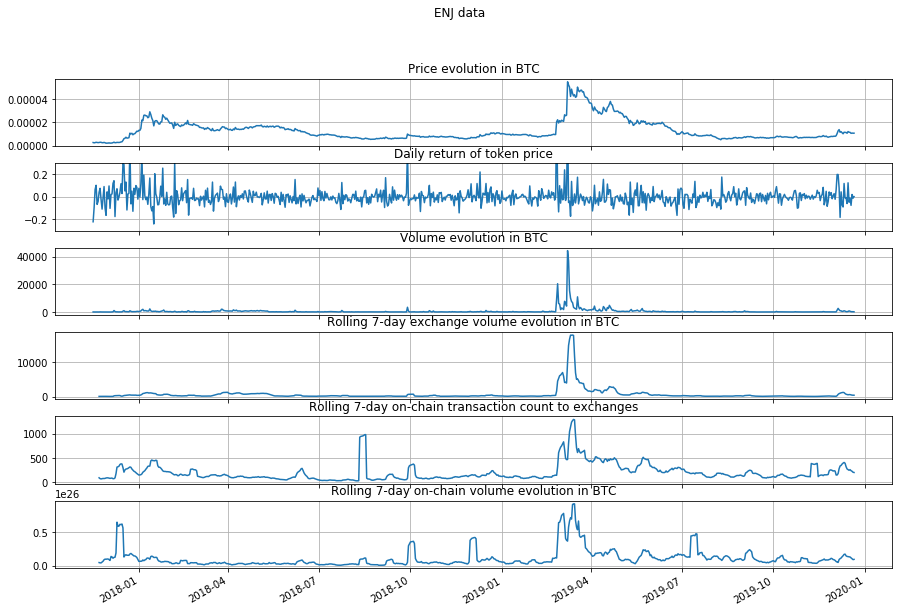

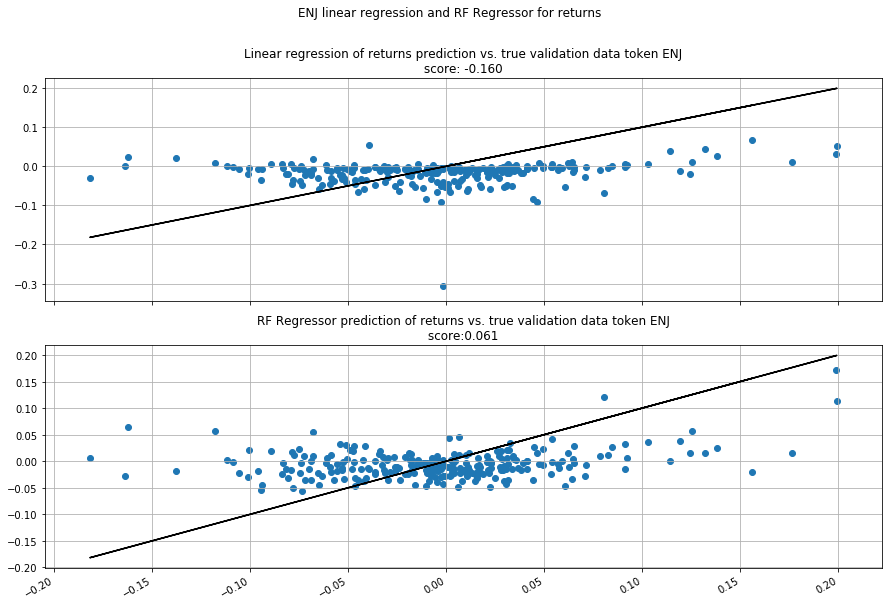

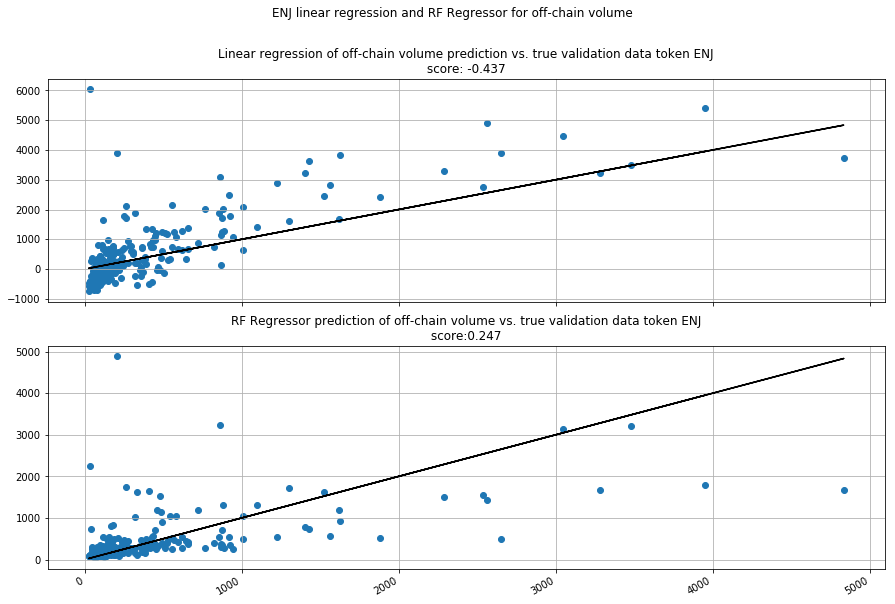

In [60]:
# hardcode our test procedure
compute_for_token('0xf629cbd94d3791c9250152bd8dfbdf380e2a3b9c', 'ENJ')

(29863, 9)

We found 29863 transactions towards exchanges. for  ./data/THETA/raw_big_query_TO_EXCHANGES.csv


(64676, 9)

We found 64676 transactions towards exchanges. for  ./data/THETA/raw_big_query_FROM_EXCHANGES.csv
number of on-chain transactions:  94083
number of duplicates:  456 

We have 691 off-chain daily intervals.
Current maximum off_chain time is 2019-12-21T01:00:00.000000000 as of 2019-12-26
Current maximum on_chain time is 2019-08-14T03:00:28.000000000 as of 2019-12-26


,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
0,0.001834,0.449515,0.400216,2.847367,-1553.989546,-1532.476451,"[1, 1]",NaN,THETA
1,0.001834,0.449515,0.400216,2.847367,-1553.989546,-1532.476451,"[1, 1]",Stock,THETA
9,0.001925,0.445032,0.375097,2.841261,-1552.006557,-1526.190843,"[2, 1]",Stock,THETA
2,0.001835,0.449474,0.400195,2.847243,-1551.989547,-1526.173833,"[1, 2]",Stock,THETA
17,0.002715,0.455531,0.114898,2.840539,-1550.151326,-1520.032993,"[3, 1]",Stock,THETA
10,0.001924,0.444940,0.375225,2.841355,-1550.006558,-1519.888225,"[2, 2]",Stock,THETA
3,0.001835,0.449459,0.400210,2.847180,-1549.989546,-1519.871214,"[1, 3]",Stock,THETA
18,0.002714,0.454928,0.106237,2.840522,-1548.152711,-1513.731760,"[3, 2]",Stock,THETA
25,0.002714,0.455522,0.114941,2.840688,-1548.151326,-1513.730375,"[4, 1]",Stock,THETA
4,0.001790,0.446942,0.391003,2.857452,-1548.034082,-1513.613130,"[1, 4]",Stock,THETA


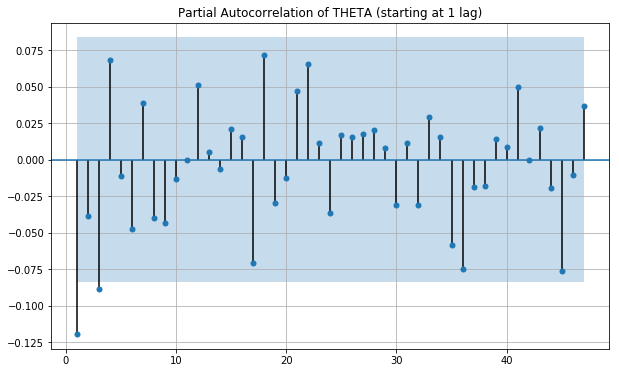

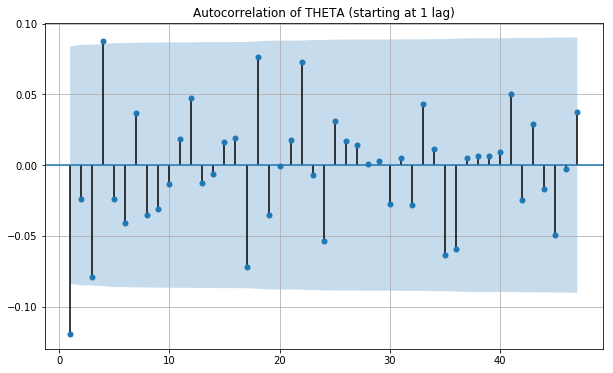

,time,to_exchanges_transactions,from_exchanges_transactions,onchain_trans,onchain_volume,close,high,low,volume,returns,intercept,realized_vol
0,2018-02-14 01:00:00,20,0,74,4.008994e+24,0.000014,0.000014,0.000013,293.24,0.018458,1,NaN
1,2018-02-15 01:00:00,14,0,67,2.388952e+24,0.000014,0.000017,0.000012,455.06,0.024568,1,NaN
2,2018-02-16 01:00:00,16,0,92,1.913670e+24,0.000014,0.000014,0.000013,289.64,-0.012931,1,NaN
3,2018-02-17 01:00:00,7,0,51,9.294357e+23,0.000015,0.000018,0.000014,423.71,0.089839,1,NaN
4,2018-02-18 01:00:00,4,0,133,9.783592e+24,0.000016,0.000017,0.000014,426.84,0.060275,1,NaN
5,2018-02-19 01:00:00,6,0,76,3.779234e+24,0.000015,0.000017,0.000015,288.21,-0.053687,1,NaN
6,2018-02-20 01:00:00,5,0,64,1.584436e+24,0.000013,0.000015,0.000013,270.49,-0.162944,1,NaN
7,2018-02-21 01:00:00,3,0,46,4.699948e+24,0.000012,0.000014,0.000012,268.80,-0.062171,1,NaN
8,2018-02-22 01:00:00,4,0,60,2.227873e+24,0.000013,0.000014,0.000012,244.91,0.085091,1,NaN
9,2018-02-23 01:00:00,0,0,62,1.051448e+24,0.000013,0.000014,0.000013,229.86,-0.027567,1,NaN


,intercept,onchain_trans,onchain_volume,high,low,volume,from_exchanges_transactions
0,1,74,4.008994e+24,0.000014,0.000013,293.24,0
1,1,67,2.388952e+24,0.000017,0.000012,455.06,0
2,1,92,1.913670e+24,0.000014,0.000013,289.64,0
3,1,51,9.294357e+23,0.000018,0.000014,423.71,0
4,1,133,9.783592e+24,0.000017,0.000014,426.84,0
5,1,76,3.779234e+24,0.000017,0.000015,288.21,0
6,1,64,1.584436e+24,0.000015,0.000013,270.49,0
7,1,46,4.699948e+24,0.000014,0.000012,268.80,0
8,1,60,2.227873e+24,0.000014,0.000012,244.91,0
9,1,62,1.051448e+24,0.000014,0.000013,229.86,0


,intercept,onchain_trans,onchain_volume,high,low,volume,from_exchanges_transactions
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,74.0,4.008994e+24,0.000014,0.000013,293.24,0.0
2,1.0,67.0,2.388952e+24,0.000017,0.000012,455.06,0.0
3,1.0,92.0,1.913670e+24,0.000014,0.000013,289.64,0.0
4,1.0,51.0,9.294357e+23,0.000018,0.000014,423.71,0.0
5,1.0,133.0,9.783592e+24,0.000017,0.000014,426.84,0.0
6,1.0,76.0,3.779234e+24,0.000017,0.000015,288.21,0.0
7,1.0,64.0,1.584436e+24,0.000015,0.000013,270.49,0.0
8,1.0,46.0,4.699948e+24,0.000014,0.000012,268.80,0.0
9,1.0,60.0,2.227873e+24,0.000014,0.000012,244.91,0.0


linear regression score of returns -0.11377420335799848
RF Regressor score of returns -0.7076189682995255
linear regression score of off-chain volume 0.284433880337408
RF Regressor score of off-chain volume -0.6363392783644723


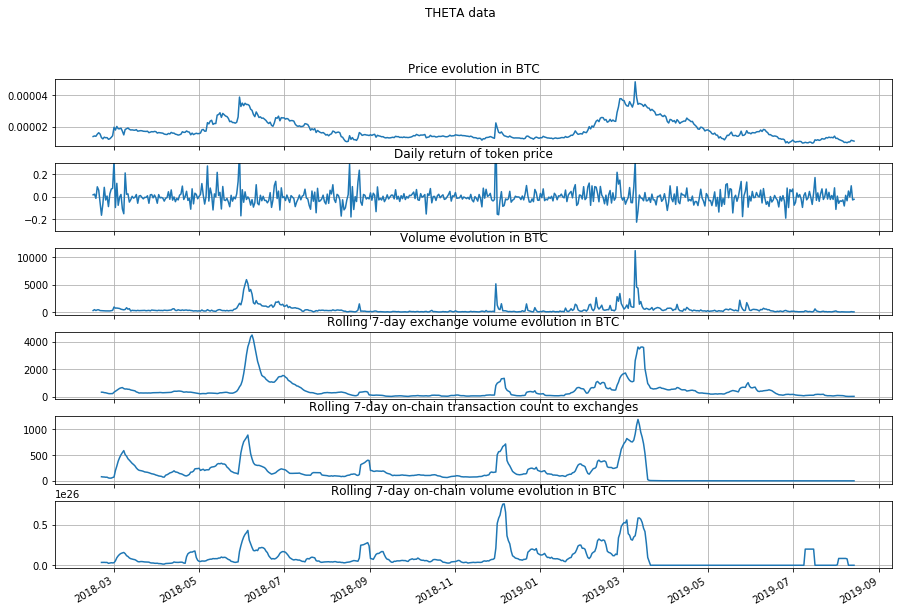

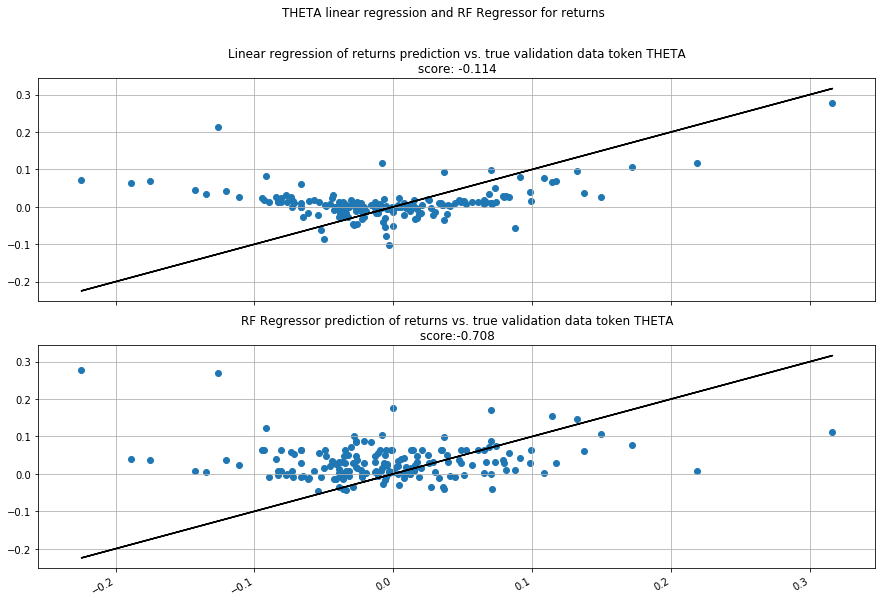

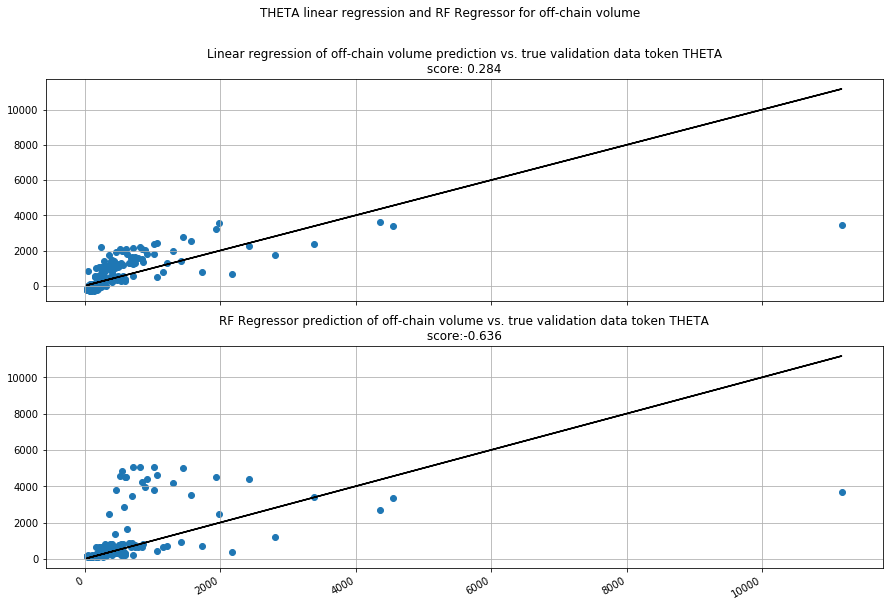

In [45]:
# hardcode our test procedure
compute_for_token('0x3883f5e181fccaf8410fa61e12b59bad963fb645', 'THETA')

(176283, 9)

We found 176283 transactions towards exchanges.
We have 863 observations.


C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code 

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code 

,omega,alpha,beta,nu,AIC,BIC,GARCH parameters,Asset,_TICKER
0,0.000058,0.115103,8.781775e-01,4.497665,-2638.643650,-2614.935146,"[1, 1]",NaN,ZRX
1,0.000058,0.115103,8.781775e-01,4.497665,-2638.643650,-2614.935146,"[1, 1]",Stock,ZRX
13,0.000057,0.142442,3.418237e-01,5.220920,-2636.426165,-2593.750859,"[2, 4]",Stock,ZRX
14,0.000057,0.170241,2.721441e-07,4.776405,-2637.472680,-2590.055674,"[2, 5]",Stock,ZRX
37,0.000133,0.129730,7.769567e-01,4.346138,-2632.064078,-2589.388771,"[5, 1]",Stock,ZRX
6,0.000057,0.203784,3.040466e-01,4.687073,-2635.465995,-2588.048988,"[1, 6]",Stock,ZRX
10,0.000032,0.086490,8.973073e-01,13.481284,-2613.942403,-2585.492199,"[2, 1]",Stock,ZRX
30,0.000065,0.159907,5.184417e-01,4.596797,-2631.768838,-2584.351831,"[4, 3]",Stock,ZRX
23,0.000057,0.170267,3.355916e-08,4.776189,-2635.472681,-2583.313974,"[3, 5]",Stock,ZRX
7,0.000057,0.203766,3.040743e-01,4.687012,-2633.465995,-2581.307288,"[1, 7]",Stock,ZRX


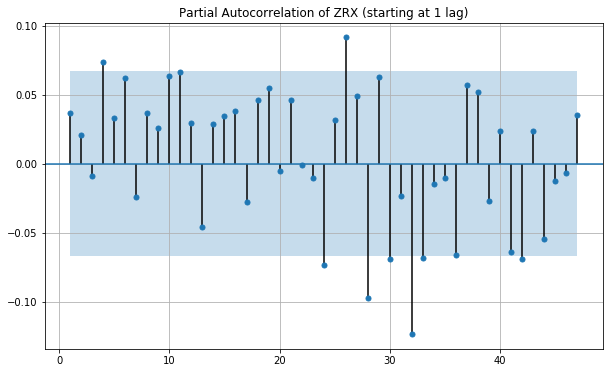

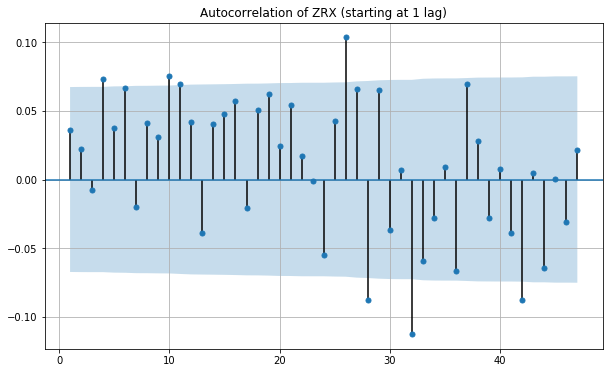

linear regression score of returns -0.02471576443475687
RF Regressor score of returns -0.8922745526835969
linear regression score of off-chain volume -2.513522298584115
RF Regressor score of off-chain volume 0.5654706271711527


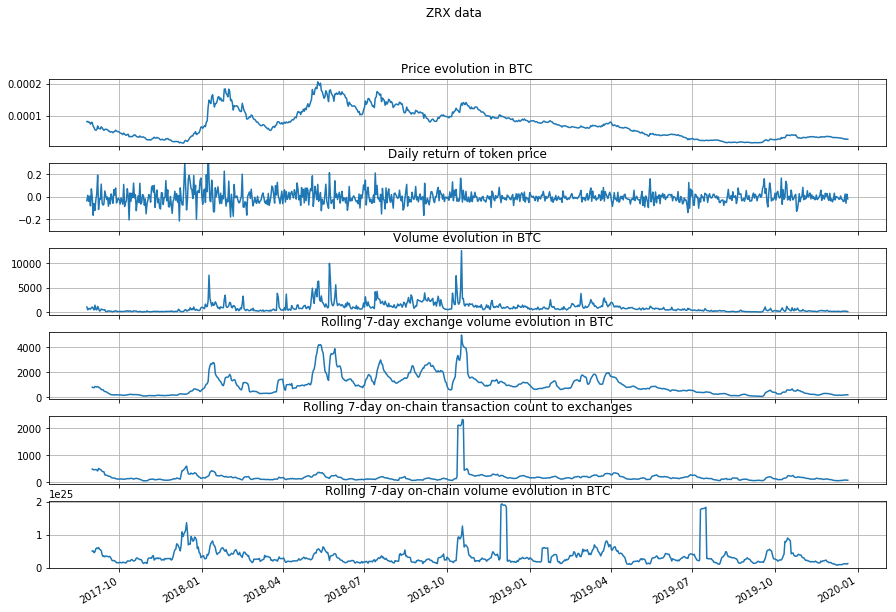

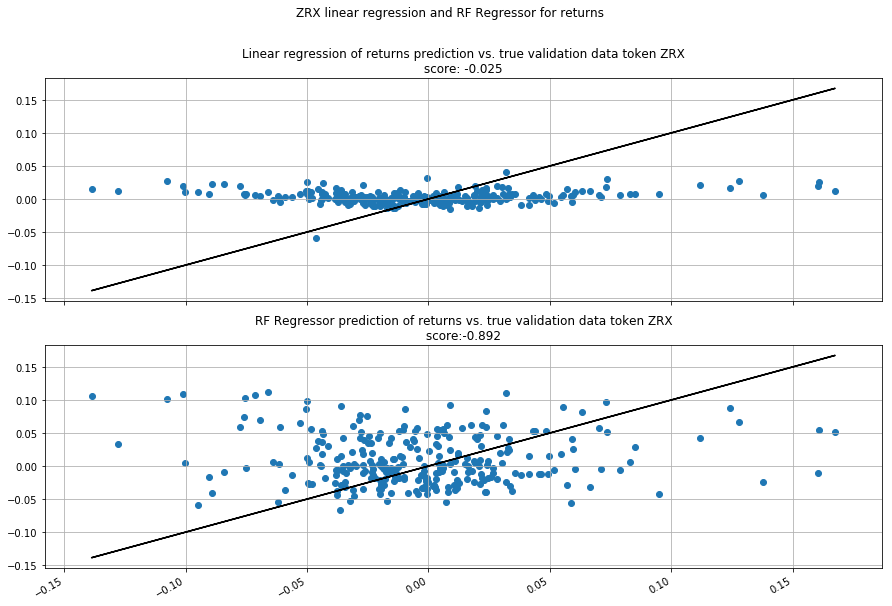

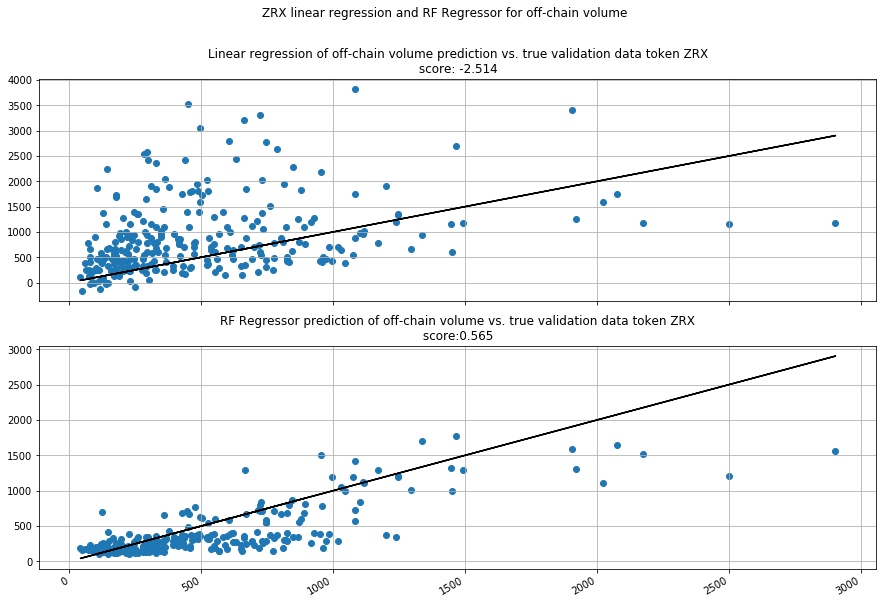

In [187]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')

### Run the program for all tokens

### Printing results in LaTeX

### Print ML techniques scores